---
# Analysing Zoo Reviews with Natural Language Processing (NLP)
---

#### Getting Started with the Notebook

Most of the code in this notebook is already written for you. Your job is to run the cells and explore the outputs to understand what's happening. You're free to explore and change parameters and see how the results change!


To run any code cell:

- Click inside the cell

- Press `Shift + Enter` (or use the ▶ button at the top of the notebook)

Make sure to run the cells **in order**, from top to bottom.

In [1]:
print("Run this cell to print this text!")

Run this cell to print this text!


---
## Introduction
---

Imagine you work at **Edinburgh Zoo** and your job is to help improve the experience for future visitors. Every day, people write online reviews describing what they liked (or didn't like) about their visit. These reviews contain valuable feedback - but they are written in free-form text and can quickly become overwhelming.

If you had only ten reviews, you might be able to read them all yourself and spot patterns. But what if you had hundreds or thousands?

That's where **Natural Language Processing (NLP)** comes in. NLP is a field of Artificial Intelligence that allows us to extract structure and meaning from human language. By combining a set of smart tools, we can automatically process visitor reviews, identify which animals are mentioned, understand the emotions expressed about them, and summarise the main opinions - all without having to read every sentence ourselves.

#### What We're Trying to Do

We want to answer questions such as:

- *Which animals do visitors **mention most**?*

- *What do people **like** or **dislike** about different animals?*

- *Are there any consistent **complaints** or **highlights**?*

- *Can we produce a **summary for each animal** based on real visitor feedback?*

To do this, we will go step by step from raw reviews to structured summaries.

#### Why Not Just Ask ChatGPT?

You might wonder: *why not simply copy all the reviews into a tool like ChatGPT and ask it to summarise them?*

There are two key reasons:

1. **Scale and Structure:** LLMs work best when given well-structured, focused inputs. Feeding in an entire review dataset - thousands of unrelated sentences - without any filtering or organisation would produce vague or unreliable outputs.

2. **Transparency and Control:** By splitting the task into parts (e.g. identifying animals, measuring sentiment, visualising results), we can understand what is happening at each stage. This not only builds trust in the results but also gives us flexibility to tune or troubleshoot specific steps.

In this notebook, we will build a simple pipeline using Python and some powerful pre-trained models to:

1. **Clean** and **prepare** the review data

2. **Find animals** in sentences

3. Identify **to what animal in the zoo** the sentence refers to 

4. Run **sentiment analysis** to detect the emotion of the sentence

5. Create plots to **visualise** sentiment per animal

6. Generate short, readable **summaries** for each animal using a language model

#### Tools We'll Use

We'll be using the following tools and libraries:

| Tool / Library                          | Purpose                                                                 |
|----------------------------------------|-------------------------------------------------------------------------|
| `pandas`                               | For organising and analysing tabular data                              |
| `transformers` (Hugging Face)          | For using pre-trained models (NER, sentiment analysis, and LLMs)       |
| `torch`                                | Works alongside `transformers` to train and run powerful ML models     |
| `spacy`                                | For splitting paragraphs into individual sentences                     |
| `matplotlib`                           | For plotting visualisations                                            |
| `re` (regular expressions)             | Temporary method for detecting animal mentions in text (to be replaced by NER) |
| `tqdm`                                 | Adds a progress bar for processes that take longer                     |
| `rapidfuzz`                            | Compares strings to fix typos and variations                           |
| Pretrained model (BERT)                | Used to detect animal names in sentences                               |
| Local large language model (Mistral-7B) | Generates natural-language summaries from grouped reviews              |

--- 
## Step 0. Set up the environment
---
This notebook has been prepared in python version 3.12.2. 

To create the environment, run the following commands in a terminal:
```bash
# Create a python environment (you can create a Conda environment instead)
python -m venv sutton_venv

# Activate environment
source sutton_venv/bin/activate

# Install packages
pip install -r requirements.txt

# Allow jupyter notebook to access the environment
python -m ipykernel install --user
```

Alternatively, if `pip install -r requirements.txt` line runs into errors, install the needed packages yourself through running:
```bash
pip install ipykernel
python -m ipykernel install --user
pip install pandas matplotlib transformers datasets spacy seqeval torch rapidfuzz 
python -m spacy download en_core_web_sm
```


To activate the environment, in VSCode:
* Select kernel -> download the recommended extensions (if prompted)
* Select kernel -> Python Environment... > NER_venv

---
## Step 1: Load and Explore the Review Data
---

We'll be using real visitor reviews collected from an online platform (TripAdvisor), where people share their experiences at Edinburgh Zoo.

To save time, the data has already been collected and lightly cleaned. It's stored in a CSV file called `edinburgh-zoo-reviews-1990.csv`, with 1990 reviews. Each row contains:
- A **title** (short summary),
- And a **full review text** (the visitor's main comments).

Run the following code cell to load the data and take a look at a few example reviews.

In [2]:
# Import the pandas library for data handling
import pandas as pd

# Load the review data from the CSV file
df = pd.read_csv("edinburgh-zoo-reviews-1990.csv")

# Change the maximum column width to display the full review
pd.set_option('display.max_colwidth', None)

# Display the first 5 rows of the dataset
df.head(5)

,title,review,date
0,Family Day Out At The Zoo,"Had an amazing time here with my little girl and her gran on a sunny day in June.Variety of animals the zoo has is incredible, plenty of places to eat and drink, great selection of play parks for kids, and the staff do an amazing job of keeping the entire zoo immaculate.We all had a magical day and would highly recommend it for a day out with the family.It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.The animal talks were highly engaging and would also highly recommend attending these when visiting.Keep up the brilliant work RZSS.",28 June 2025
1,An excellent day out,We visited using the season ticket from our local zoo. From arrival we were made very welcome. Staff took time out to talk to us and tell us about the animals. We loved the large enclosures that the animals had to roam in and had great views of many during the day. Thank you everyone for a great day!,25 June 2025
2,Our favourite place for our days off,We’re members and love the zoo.So many different animals too see and easy to get to by the 26 or 31 bus from the Center.It is a challenging zoo as it’s all on hill so be prepared to get your hike on but it’s all worth it.Staff are great and always happy to helpWorth a visit we almost go every other month,20 June 2025
3,Youth club day out,"Brilliant day out with the Youth Club at the Zoo, we travelled all the way up from County Durham and the zoo staff couldnt have been more helpful from initial contact to collecting the tickets on the day. The zoo was clean and tidy and the group loved it with the penguins being a firm favourite. We even took advantage of the lunch voucher system and the visit triggered some additional workshops following the visit.",14 June 2025
4,Best zoo,"This was without a doubt one of the best zoo visits we've ever had (helped by the fact we stayed at the Holiday Inn on sight and were offered discounted tickets after 14:00, so therefore the crowds had also dispersed) Despite the layout being steep, the views over Edinburgh were superb once at the top, everything was well laid out and easy to find. Just wish we'd had longer, but I'm sure we will return!",12 June 2025


<div style="
  border-left: 5px solid #4caf50;
  background: #f6ffed;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Try this:</strong> Change the number inside <code>head()</code> to see more reviews!
</div>

---
## Step 2: Prepare the Review Text
---

Before we can analyse the reviews, we need to **prepare the text**. Online reviews - like those from TripAdvisor - are often informal. That means they might contain:

- Long paragraphs with multiple ideas  
- Inconsistent punctuation or formatting  
- Occasional typos or grammar mistakes  

All of this can make it harder for our analysis to be accurate or meaningful. So before we go further, we'll do one key thing:

- **Split each review into individual sentences** - to break down complex reviews into smaller, more focused pieces of text.

<!-- 💡 Why Split Reviews Into Sentences? -->
<div style="
  border-left: 5px solid #ffc107;
  background: #fff8e1;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> Why Split Reviews Into Sentences?</strong><br>
  A single review can mention several animals - and express very different emotions about each one. For example:
  <br><br>
  <em>“The penguins were adorable! But the food was overpriced. They charged us £15 for two dry sandwiches. It's outrageous!”</em>
  <br><br>
  If we analyse the whole review at once, we might detect the word <code>penguins</code> and assume the reviewer had a bad experience with them. That would be misleading.
  <br><br>
  To avoid this, we will analyse <strong>sentiment at the sentence level</strong>, so we can link specific opinions to specific animals more reliably.
</div>

<!-- ⚙️ How Does Sentence Splitting Work? -->
<div style="
  border-left: 5px solid #007acc;
  background: #f0f8ff;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> How Does Sentence Splitting Work?</strong><br>
  We'll use a pre-trained model from the <code>spaCy</code> NLP library. It’s been trained on large collections of real-world English - including books, news articles, and websites - to learn where sentences begin and end.
  <br><br>
  These models are fast, reliable, and much easier to use than writing custom rules by hand. Curious? You can explore spaCy's models here:  
  <a href="https://spacy.io/models/en" target="_blank">https://spacy.io/models/en</a>
</div>

#### Let's Try It Out

Let's try applying the `spaCy` model to split one full review into individual sentences.

In [3]:
# Display a full review from the dataset
df["review"].iloc[5]

'Loved seeing all the different animals especially the penguins and giraffes! Great choice of gifts in gift shop. Staff all friendly, approachable and helpful. Despite the rain it was an enjoyable experience!'

You should see something like:

> Loved seeing all the different animals especially the penguins and giraffes! Great choice of gifts in gift shop. Staff all friendly, approachable and helpful. Despite the rain it was an enjoyable experience!

Now let's split this into cleaner, shorter sentences:

In [4]:
import spacy

# Load the pre-trained English NLP model from spaCy
nlp = spacy.load("en_core_web_sm")

# Get the review text and clean it slightly
raw_text = df["review"].iloc[5]
cleaned_text = raw_text.replace("\n", " ").strip()

# Apply the NLP model to split into sentences
doc = nlp(cleaned_text)
sentences = [sent.text.strip() for sent in doc.sents]

# Display each sentence one by one
for i, sentence in enumerate(sentences, 1):
    print(f"{i}. {sentence}")

1. Loved seeing all the different animals especially the penguins and giraffes!
2. Great choice of gifts in gift shop.
3. Staff all friendly, approachable and helpful.
4. Despite the rain it was an enjoyable experience!


The output should look like:

> 1. Loved seeing all the different animals especially the penguins and giraffes!
> 2. Great choice of gifts in gift shop.
> 3. Staff all friendly, approachable and helpful.
> 4. Despite the rain it was an enjoyable experience!

#### Why This Is Helpful

This result shows how a single paragraph can be neatly split into focused thoughts:

- **Sentence 1** talks about *animals* (penguins and giraffes)

- **Sentence 2** is about the *gift shop*

- **Sentence 3** focuses on the *staff*

- **Sentence 4** reflects on the *overall experience*


By working at the sentence level, we can now link specific opinions to specific topics - like *individual animals* - instead of just tagging a vague overall mood.

#### Now Let's Do This for Every Review

We've now seen how to split a single review into sentences. Next, we'll apply this to the entire dataset.

This will give us:

- One sentence per row

- Clearer, more focused units of analysis

- A better foundation for tasks like animal detection and sentiment analysis

Let's build the full sentence-level dataset now.

In [5]:
# Create an empty list to hold the results
split_sentences = []

# Loop through each review in the dataset
for idx, review in df["review"].items():
    # Clean up formatting
    cleaned = review.replace("\n", " ").strip()
    
    # Apply the NLP model
    doc = nlp(cleaned)
    
    # Extract individual sentences
    for sentence in doc.sents:
        split_sentences.append({
            "Review Index": idx,
            "Sentence": sentence.text.strip()
        })

# Create a new DataFrame with one sentence per row
sentences_df = pd.DataFrame(split_sentences)

# Show a preview of the result
sentences_df.head(20)

,Review Index,Sentence
0,0,Had an amazing time here with my little girl and her gran on a sunny day in June.
1,0,"Variety of animals the zoo has is incredible, plenty of places to eat and drink, great selection of play parks for kids, and the staff do an amazing job of keeping the entire zoo immaculate."
2,0,We all had a magical day and would highly recommend it for a day out with the family.
3,0,It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.
4,0,The animal talks were highly engaging and would also highly recommend attending these when visiting.
5,0,Keep up the brilliant work RZSS.
6,1,We visited using the season ticket from our local zoo.
7,1,From arrival we were made very welcome.
8,1,Staff took time out to talk to us and tell us about the animals.
9,1,We loved the large enclosures that the animals had to roam in and had great views of many during the day.


---
## Step 3: Find the Animals!
---

Now that each review is split into individual sentences, we can look more closely at **what** people are talking about.

In this step, we'll use a technique called **Named Entity Recognition (NER)** to detect specific animals mentioned in the text - like *penguins*, *giraffes*, or *tigers*.

NER is part of a field called **Natural Language Processing (NLP)**. It's used to automatically identify and label important things in text, such as:

- People's names (e.g. *Jane Goodall*)
- Locations (e.g. *Edinburgh Zoo*)
- Organisations (e.g. *RZSS*)
- Products, dates, times…  
...and yes, even **animals**.

<div style="
  border-left: 5px solid #007acc;
  background: #f0f8ff;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong> What's the Point?</strong><br>
  By tagging animal mentions in each sentence, we'll be able to:
  <ul style="margin-top: 0.5em; margin-bottom: 0;">
    <li>Count which animals are most talked about</li>
    <li>Link animals to specific opinions and emotions</li>
    <li>Create fun visualisations of animal mentions</li>
  </ul>
  <p style="margin-top: 0.75em; margin-bottom: 0;">
    This helps us understand how visitors feel about different parts of the zoo.
  </p>
</div>

Next, we'll load a pre-trained NER model (like the one from <code>spaCy</code>), run it on our sentence-level DataFrame, and extract any animals it can find.

Later, we'll combine this with **sentiment analysis** to detect *how* people feel about each animal.  

Let's get ready to go animal spotting!

#### Let's see how it works under the hood!

The model has already been trained, and we can load it using the `transformers` library. To do this, we need two components: the **tokenizer** and the **model** itself.  

These are loaded in the next cell:

In [7]:
# Import the necessary modules to load the pre-trained NER model
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Specify the path of the folder where the model and tokenizer are stored
LOAD_MODEL_PATH = "animal-ner-model"

# Load the pre-trained NER model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(LOAD_MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(LOAD_MODEL_PATH)

Now we need to prepare the sentences in our dataset so they can be passed into the model. But we can't do that directly — the model doesn't actually understand plain text.  

Instead, we must first **tokenise** the sentences: that is, break them down into smaller units called *sub-words*.  

To do this, we'll use a function called `tokenize_sentences`. Let’s see how it works on an example sentence:

In [8]:
# Write a sentence to tokenize
# Change this sentence to whatever you want!
example_sent = "We loved to see the tigers and penguins at the zoo."

# Tokenize the example sentence
def tokenize_sentences(sentences):
    """
    Tokenizes a list of sentences and returns the encodings.
    """
    return tokenizer(
        sentences,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
        return_offsets_mapping=True
    )

encodings = tokenize_sentences([example_sent])

# Get the information we need out of the encodings
input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
offset_mappings = encodings["offset_mapping"]

# Use the encodings information to annotate the sentence
import torch
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

# Use the function "argmax" to extract the predictions from the model's output
predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions to labels
labels = [model.config.id2label[pred_id.item()] for pred_id in predictions[0]]

# Show the results
print("Original sentence:", example_sent)

print("Result:")
pd.DataFrame({
    "Token":            tokenizer.convert_ids_to_tokens(encodings["input_ids"][0]),
    "Input IDs":        input_ids[0].tolist(),
    "Offset Mapping":   offset_mappings[0].tolist(),
    "Predictions":      predictions[0].tolist(),
    "Predicted Label":  labels
}).set_index("Token").transpose()

Original sentence: We loved to see the tigers and penguins at the zoo.
Result:


Token,[CLS],We,loved,to,see,the,tiger,##s,and,pen,##guin,##s,at,the,zoo,.,[SEP]
Input IDs,101,1284,3097,1106,1267,1103,13778,1116,1105,8228,25913,1116,1120,1103,15003,119,102
Offset Mapping,"[0, 0]","[0, 2]","[3, 8]","[9, 11]","[12, 15]","[16, 19]","[20, 25]","[25, 26]","[27, 30]","[31, 34]","[34, 38]","[38, 39]","[40, 42]","[43, 46]","[47, 50]","[50, 51]","[0, 0]"
Predictions,0,0,0,0,0,0,1,2,0,1,2,2,0,0,0,0,0
Predicted Label,O,O,O,O,O,O,B-ANIMAL,I-ANIMAL,O,B-ANIMAL,I-ANIMAL,I-ANIMAL,O,O,O,O,O


You may have noticed something interesting in the table above...

Tokenising doesn't always mean splitting text into whole words. For example, the word *"penguins"* is tokenised into three smaller parts (called *tokens*): `"pen"`, `"##guin"`, and `"##s"`.

<div style="
  border-left: 5px solid #2196f3;
  background: #e3f2fd;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>What's a token, exactly?</strong><br>
  A <em>token</em> is the basic unit that the model understands — and in modern models like this one, most tokens are actually <strong>subwords</strong>.<br><br>
  That means a single word like <code>penguins</code> might get split into multiple tokens: <code>"pen"</code>, <code>"##guin"</code>, and <code>"##s"</code>.<br><br>
  So:
  <ul style="margin-top: 0.25em; margin-bottom: 0;">
    <li><strong>All subwords are tokens</strong></li>
    <li><strong>But not all tokens are full words!</strong></li>
  </ul>
</div>

The `"##"` symbol means that the token continues from the previous one — it's part of the same word.

Why does this happen? The model has a limited vocabulary of known sub-word units. Rare or unusual words are broken down into smaller chunks, while common words are often kept whole.

That's why *"tigers"* (a more common word) becomes just `"tiger"` and `"##s"`, while *"penguins"* is split into three tokens.

<div style="
  border-left: 5px solid #4caf50;
  background: #f6ffed;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Try it yourself:</strong><br>
  Change the sentence in <code>example_sent</code> above to something new, and see how the tokenisation changes!  
  Can you find a rare or long word that gets split into lots of tokens?  
  What about an animal that's only partly recognised?
</div>

#### Use the model on all sentences in the dataset

The next cell contains all the code needed to:
- get predictions from the model (just like we did above), and  
- convert detected animal tokens (like `pen`, `##guin`, `##s`) back into the full word (`penguins`).

You're welcome to explore the code if you're curious — but there's no need to understand how it works!

Running the model on *all* sentences in the dataset would take a long time on this computer.  
**Why?** Because this machine doesn't have access to a **GPU** (*Graphics Processing Unit*) — a special chip (like a graphics card in a gaming PC) that can perform lots of calculations at once.

Machine learning models (like the one we're using to detect animal names) run much faster on a GPU. Without one, everything slows down — like trying to play a high-end video game on an old laptop.

To keep things quick, we'll just run the model on 500 sentences (just to show it works!). After that, we'll load a pre-processed version of the full dataset.

In [9]:
# Don't worry if this looks complicated — this part of the code is here to help the model
# figure out where the animal names are in each sentence. It’s been written for you!

# === Annotate a subset of 500 review sentences
from tqdm import tqdm  # Used to create a progress bar
import torch

# === Helper functions
def flush_entity(entities, entity_token_idxs, offsets, sentence):
    """
    Save the entity into the 'entities' list.
    """
    # Get character-level start and end positions of the whole entity
    span_offsets = [offsets[i].tolist() for i in entity_token_idxs]
    start_char = span_offsets[0][0]
    end_char = span_offsets[-1][1]

    # Save the entity in the list as a tuple: (animal name, start position, end position)
    new_entity = (sentence[start_char:end_char].strip().lower(), start_char, end_char)

    # Avoid duplicates (e.g. in cases like to ##rt ##oise where tokens are inconsistently labelled)
    if new_entity not in entities:
        entities.append(new_entity)

    # Reset the tracker for the next entity
    entity_token_idxs = []

    return entities, entity_token_idxs

def backtrack_to_word_start(input_ids_sent, tok_idx, entity_token_idxs):
    """Backtracks from a subword token to the start of the full word."""

    # If the initial token is a subword, search for the start of the word
    token_text = tokenizer.convert_ids_to_tokens([input_ids_sent[tok_idx]])[0]
    if token_text.startswith("##"):

        # Move backwards to find the start of the word
        prev_idx = tok_idx - 1

        while prev_idx >= 0:
            entity_token_idxs.insert(0, prev_idx)

            token_text = tokenizer.convert_ids_to_tokens([input_ids_sent[prev_idx]])[0]
            if token_text.startswith("##"):
                prev_idx -= 1
            else:
                break

    return entity_token_idxs

def forwardtrack_to_word_end(input_ids_sent, entity_token_idxs):
    """Moves forward to include subword tokens that are part of the same word (e.g. ##e from giraffe)."""

    next_idx = entity_token_idxs[-1] + 1

    while next_idx < len(input_ids_sent):
        next_token_text = tokenizer.convert_ids_to_tokens([input_ids_sent[next_idx]])[0]

        if next_token_text.startswith("##"):
            entity_token_idxs.append(next_idx)
            next_idx += 1
        else:
            break

    return entity_token_idxs

def get_entities_from_predictions(preds, input_ids_sent, offsets):
    """
    Extracts entities from the model’s predictions and input IDs.
    """

    entity_token_idxs = []  # Holds indices of tokens currently forming an entity
    entities = []           # Will store all extracted animal mentions for the sentence
    label = "O"             # Initial label (O = Outside entity)

    for tok_idx, pred_id in enumerate(preds):
        previous_label = label
        label = model.config.id2label[pred_id.item()]
        start, end = offsets[tok_idx].tolist()

        # Skip special tokens ([CLS], [SEP], padding)
        if start == end == 0:
            continue

        # Skip non-entity tokens
        if label == "O":
            continue

        # Correct cases of I-ANIMAL without a preceding B-ANIMAL
        if (label == "I-ANIMAL") and (previous_label not in {"B-ANIMAL", "I-ANIMAL"}):
            label = "B-ANIMAL"

        # If we’ve already been tracking an entity and this token is not part of it,
        # save the entity before starting a new one
        if (entity_token_idxs != []) and (label != "I-ANIMAL"):
            entity_token_idxs = forwardtrack_to_word_end(input_ids_sent, entity_token_idxs)
            entities, entity_token_idxs = flush_entity(entities, entity_token_idxs, offsets, sentence)

        if label == "B-ANIMAL":
            entity_token_idxs = [tok_idx]
            entity_token_idxs = backtrack_to_word_start(input_ids_sent, tok_idx, entity_token_idxs)

        elif label == "I-ANIMAL":
            entity_token_idxs.append(tok_idx)

    # Final check in case sentence ends with an entity
    if entity_token_idxs:
        entities, entity_token_idxs = flush_entity(entities, entity_token_idxs, offsets, sentence)

    animals = [ent[0] for ent in entities]
    spans = [tuple(ent[1:3]) for ent in entities]

    return animals, spans

# === Extract the animals!

# "Batch size" refers to how many sentences we process at once.
# Processing more at once is faster, but uses more memory.
batch_size = 16

# Initialise a list to store the annotated sentences
NER_animals = []

# Convert the DataFrame sentences into a list
all_sentences = list(sentences_df["Sentence"])

# Only run on a subset of sentences to save time (running on all would take ~5 minutes)
all_sentences = all_sentences[:512]

# Use tqdm to show progress while we find animals in each batch
for i in tqdm(range(0, len(all_sentences), batch_size), desc="Finding animals in text"):
    sentences = all_sentences[i:i+batch_size]

    # Tokenise the sentences in the batch
    encodings = tokenize_sentences(sentences)

    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]
    offset_mappings = encodings["offset_mapping"]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    predictions = torch.argmax(outputs.logits, dim=-1)

    for sent_idx, sentence in enumerate(sentences):
        preds = predictions[sent_idx]
        input_ids_sent = input_ids[sent_idx]
        offsets = offset_mappings[sent_idx]

        # Extract animals and character spans
        animals, spans = get_entities_from_predictions(preds, input_ids_sent, offsets)

        NER_animals.append({
            "review_sentence": sentence,
            "animals": animals,
            "spans": spans
        })

# Convert to DataFrame for easier use
animal_sentences_df = pd.DataFrame(NER_animals)

# The above only ran on a small subset — now load the full version (pre-processed)
animal_sentences_df = pd.read_json("NER_animals.json")

# Filter out any rows where no animals were detected
animal_sentences_df = animal_sentences_df[animal_sentences_df["animals"].apply(lambda x: len(x) > 0)]

# Show a few examples
animal_sentences_df.head(3)

Finding animals in text: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


,review_sentence,animals,spans
3,It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.,"[lions, tigers]","[[53, 58], [63, 69]]"
16,The zoo was clean and tidy and the group loved it with the penguins being a firm favourite.,[penguins],"[[59, 67]]"
21,Loved seeing all the different animals especially the penguins and giraffes!,"[penguins, giraffes]","[[54, 62], [67, 75]]"


Now that we have the annotated dataset, let's take a look at how many different animal mentions it found.

In [10]:
# Count how many times each animal was mentioned across all sentences
animals_mention_counts = (
    animal_sentences_df.explode("animals")["animals"]
    .value_counts()
    .sort_values(ascending=False)
)

# How many different animals were mentioned?
print(f"Number of different animals mentioned: {len(animals_mention_counts)}")

# Show the top 10 most frequently mentioned animals
animals_mention_counts.head(10)

Number of different animals mentioned: 478


animals
pandas          680
penguins        456
panda           314
penguin         289
koalas          188
lions           148
giraffes        144
tiger           125
monkeys         113
giant pandas    109
Name: count, dtype: int64

The Edinburgh Zoo doesn't have *that* many animals! What's going on?

Well, people often refer to the same animal in different ways. For example, `pandas`, `panda`, and `giant pandas` might all refer to the same species.

The process of grouping these different variations into a single, standard form is called **normalisation** – and that's what we'll do next!

---
## Step 4: Normalise the animal names!
---

Let's take a closer look at how people refer to the same animal in different ways.  

For example, how many different ways do people talk about penguins? We'll use a quick shortcut: searching for all detected entities that contain `peng` in their names.

In [11]:
# Choose the string you want to search for (e.g., part of an animal name)
string_to_search = "peng"

# Filter the list of animal mentions to include only those containing the search string
# This is case-insensitive, so it will match 'Penguin', 'penguins', 'Emperor Penguin', etc.
filtered_animals = animals_mention_counts[animals_mention_counts.index.str.contains(string_to_search, case=False)]

# Show the results
filtered_animals

animals
penguins            456
penguin             289
king penguins         8
pengiuns              2
emperor penguins      2
penguin rock          2
thepenguin            1
penguin march         1
penguin parade        1
penguins3             1
penguinsnow           1
Name: count, dtype: int64

As you can see, people refer to `penguins` in lots of different ways.  
We need a way to recognise that all these mentions point to the same zoo animal!

What we've done just now is a simple **string match**.  
That means the computer is looking for the exact sequence of letters you typed — nothing more, nothing less.  

So if you search for `"peng"`, it will only find words that contain those exact letters in that order.  
It won't catch things like `"pinguin"` (a possible typo), or `"penguin exhibit"` if the entity was tokenised strangely.

We need a smarter way to group together different spellings, formats, and even occasional misspellings of the same animal name.  
This process is called **normalising** the entities.

<div style="
  border-left: 5px solid #4caf50;
  background: #f6ffed;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Try this:</strong><br>
  Change the <code>string_to_search</code> to search for other animals!  
  For example: <code>"cat"</code>, <code>"giraf"</code>, <code>"bear"</code>
</div>

#### Our Custom Animal List

We've put together a list of animals currently found at **Edinburgh Zoo**,  
along with common ways visitors might refer to them.

This includes:

- Official species names (e.g. `"Northern rockhopper penguin"`)
- Simpler terms (e.g. `"penguin"`, `"giraffe"`, `"tiger"`)
- Nicknames and informal aliases (e.g. `"bearcat"` for a *binturong*, `"duck"` for a *pochard*)

You can see the full list in the cell below:

In [12]:
# ALIAS DICTIONARY
edinburgh_zoo_animal_aliases = {
    "Alpaca": ["alpaca"],
    "Asian small clawed otter": ["asian otter", "small clawed otter", "otter"],
    "Asiatic lion": ["asiatic lion", "lion"],
    "Baer's pochard": ["pochard", "baer's pochard", "duck"],
    "Bagot goat": ["bagot goat", "goat"],
    "Banteng": ["banteng", "wild cattle"],
    "Binturong": ["binturong", "bearcat"],
    "Blue poison dart frog": ["blue poison dart frog", "poison dart frog", "dart frog", "frog"],
    "Brown capuchin": ["brown capuchin", "capuchin monkey", "capuchin"],
    "Buff-cheeked gibbon": ["buff-cheeked gibbon", "gibbon"],
    "Cape porcupine": ["cape porcupine", "porcupine"],
    "Capybara": ["capybara", "capy", "capys"],
    "Cheetah": ["cheetah"],
    "Chilean flamingo": ["chilean flamingo", "flamingo"],
    "Chilean rose tarantula": ["chilean rose tarantula", "tarantula", "spider"],
    "Chimpanzee": ["chimpanzee", "chimp", "chimps"],
    "Chinese goral": ["chinese goral", "goral"],
    "Common squirrel monkey": ["common squirrel monkey", "squirrel monkey"],
    "Coppery titi monkey": ["coppery titi monkey", "titi monkey"],
    "Cotton-top tamarin": ["cotton-top tamarin", "tamarin"],
    "Crowned lemur": ["crowned lemur", "lemur"],
    "Drill": ["drill"],
    "East African crowned crane": ["east african crowned crane", "crowned crane", "crane"],
    "Eastern white pelican": ["eastern white pelican", "pelican"],
    "Gelada baboon": ["gelada", "gelada baboon", "baboon"],
    "Gentoo penguin": ["gentoo penguin", "penguin"],
    "Giant African land snail": ["giant african land snail", "land snail", "snail"],
    "Giant anteater": ["giant anteater", "anteater"],
    "Goeldi's monkey": ["goeldi's monkey", "goeldi monkey"],
    "Greater one-horned rhinoceros": ["greater one-horned rhinoceros", "rhinoceros", "rhino"],
    "Grevy's zebra": ["grevy's zebra", "zebra"],
    "Ground cuscus": ["ground cuscus", "cuscus"],
    "Japanese macaque": ["japanese macaque", "macaque"],
    "King penguin": ["king penguin", "penguin"],
    "Kirk's dik-dik": ["kirk's dik-dik", "dik-dik"],
    "L'Hoest's monkey": ["lhoest's monkey"],
    "Land hermit crab": ["land hermit crab", "hermit crab", "crab"],
    "Large hairy armadillo": ["large hairy armadillo", "armadillo"],
    "Leopard tortoise": ["leopard tortoise", "tortoise"],
    "Linne's two-toed sloth": ["linne's two-toed sloth", "two-toed sloth", "sloth"],
    "Lowland nyala": ["lowland nyala", "nyala"],
    "Malayan sun bear": ["malayan sun bear", "sun bear", "bear"],
    "Meerkat": ["meerkat"],
    "Northern Luzon giant cloud rat": ["northern luzon giant cloud rat", "cloud rat", "rat"],
    "Northern rockhopper penguin": ["northern rockhopper penguin", "rockhopper penguin", "penguin"],
    "Nubian giraffe": ["nubian giraffe", "giraffe"],
    "Pallas's cat": ["pallas's cat", "pallas cat"],
    "Pied imperial pigeon": ["pied imperial pigeon", "pigeon"],
    "Prevost's squirrel": ["prevost's squirrel", "squirrel"],
    "Przewalski's wild horse": ["przewalski's wild horse", "wild horse", "horse"],
    "Pygmy hippo": ["pygmy hippo", "hippopotamus", "hippo"],
    "Queensland koala": ["queensland koala", "koala"],
    "Red panda": ["red panda"],
    "Giant panda": ["giant", "panda", "giant panda"],
    "Red river hog": ["red river hog", "hog", "pig"],
    "Red-bellied lemur": ["red-bellied lemur", "lemur"],
    "Red-fronted macaw": ["red-fronted macaw", "macaw", "parrot"],
    "Reef tank": ["reef tank", "reef", "aquarium"],
    "Ring-tailed lemur": ["ring-tailed lemur", "lemur"],
    "Southern cassowary": ["southern cassowary", "cassowary"],
    "Southern pudu": ["southern pudu", "pudu"],
    "Southern three-banded armadillo": ["southern three-banded armadillo", "three-banded armadillo", "armadillo"],
    "Sumatran tiger": ["sumatran tiger", "tiger"],
    "Sun beetle": ["sun beetle", "beetle"],
    "Swamp wallaby": ["swamp wallaby", "wallaby"],
    "Turkmenian markhor": ["turkmenian markhor", "markhor", "goat"],
    "Visayan spotted deer": ["visayan spotted deer", "spotted deer", "deer"],
    "Visayan warty pig": ["visayan warty pig", "warty pig", "pig"],
    "Waldrapp ibis": ["waldrapp ibis", "ibis"],
    "Western grey kangaroo": ["western grey kangaroo", "kangaroo"],
    "Wildcat": ["wildcat", "cat"],
    "Monkeys": ["monkey"] # General category for unspecified monkey mentions
}

By checking each of the detected animal names against our list of aliases, we can automatically group all the different ways people refer to the same zoo animal.

But it's not always that simple.

People often make **typos** in their reviews — like writing `"pengvins"` instead of `"penguins"` — or they might describe animals in unusual ways. So we need a smarter way to figure out what they’re actually talking about.

Here's how we handle it:
1. **Fix typos** using an algorithm that checks whether a word is *close enough* to something in our list (e.g. `"pinguin"` → `"penguin"`).
2. **Lemmatise** the animal names — this means converting words into their simplest form.  
   For example, `"penguins"` becomes `"penguin"`, so that plurals and slight variations are grouped together.
3. **Check for partial matches**, such as mapping `"lion cub"` to `"lion"`.

Once we've done all that, we use our alias dictionary to map each cleaned-up name to its proper **species** — for example:  
`"penguin"` → `"Northern rockhopper penguin"`  
`"giraffe"` → `"Nubian giraffe"`

This gives us a clean, consistent list of species for each sentence — no matter how the animals were originally described.  
That way, we can clearly understand what visitors are saying about each animal in the zoo!

In [13]:
import spacy
nlp = spacy.load("en_core_web_sm")

def normalise_entity(entity: str) -> str | None:
    """
    Use spaCy to convert each word in the entity to its base form (lemma).
    """
    entity = entity.strip()

    # Return None for empty strings
    if entity == "":
        return None
    
    # Lemmatise each word and convert to lowercase
    doc = nlp(entity)
    norm_entity = " ".join([doc[i].lemma_.lower() for i in range(len(doc))])

    return norm_entity

from rapidfuzz.distance import JaroWinkler

def correct_misspelled_animal(misspelled: str, aliases: set, threshold=0.90):
    """
    Use Jaro-Winkler similarity to correct misspellings.
    Returns the best match if it is similar enough (above threshold).
    """
    best_match = None
    best_score = 0
    for animal in aliases:
        score = JaroWinkler.similarity(misspelled, animal)
        if score > best_score:
            best_score = score
            best_match = animal

    return best_match if best_score >= threshold else None

def map_to_species(norm_animal: str, normalised_animals_mapping: dict) -> str | None:
    """
    Attempt to map the normalised entity to a zoo species using:
    1. Direct alias matching
    2. Word-level partial matching (e.g. 'lion cub' → 'lion')
    3. Typo correction using fuzzy matching
    """

    # Step 1: Exact match to a known alias
    if norm_animal in normalised_animals_mapping:
        return normalised_animals_mapping[norm_animal]
    
    # Step 2: Partial match (any word in the phrase matches an alias)
    for word in norm_animal.split(" "):
        if word in normalised_animals_mapping:
            return normalised_animals_mapping[word]

    # Step 3: Fuzzy match for likely misspellings
    species = correct_misspelled_animal(norm_animal, set(normalised_animals_mapping.keys()))
    if species:
        return normalised_animals_mapping[species]
    
    # Step 4: No match found
    return None

# Create a mapping from each normalised alias to the correct species name
normalised_animals_mapping = {
    normalise_entity(alias): species
    for species, aliases in edinburgh_zoo_animal_aliases.items()
    for alias in aliases
}

# Apply lemmatisation to each detected animal name
animal_sentences_df["norm_animals"] = animal_sentences_df["animals"].apply(
    lambda x: [normalise_entity(ent) for ent in x]
)

# Map each normalised animal to the zoo species
animal_sentences_df["species"] = animal_sentences_df["norm_animals"].apply(
    lambda x: [map_to_species(norm_animal, normalised_animals_mapping) for norm_animal in x]
)

# Preview the results
animal_sentences_df.head()

,review_sentence,animals,spans,norm_animals,species
3,It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.,"[lions, tigers]","[[53, 58], [63, 69]]","[lion, tiger]","[Asiatic lion, Sumatran tiger]"
16,The zoo was clean and tidy and the group loved it with the penguins being a firm favourite.,[penguins],"[[59, 67]]",[penguin],[Northern rockhopper penguin]
21,Loved seeing all the different animals especially the penguins and giraffes!,"[penguins, giraffes]","[[54, 62], [67, 75]]","[penguin, giraffe]","[Northern rockhopper penguin, Nubian giraffe]"
28,We were lucky enough to get a good look at the sloth who put on a little show!,[sloth],"[[47, 52]]",[sloth],[Linne's two-toed sloth]
29,The penguins were great too.,[penguins],"[[4, 12]]",[penguin],[Northern rockhopper penguin]


And with that, the sentences are now normalised! Let's check the penguins again — have we managed to group all their different mentions under the same species?

In [14]:
# Select the species you want to search for
species = "Northern rockhopper penguin"

# Find all sentences that mention this species
filtered_sentences = animal_sentences_df[animal_sentences_df["species"].apply(lambda x: species in x)]

print(f"Found {len(filtered_sentences)} sentences mentioning the species '{species}'. Here are 5 examples:")
filtered_sentences.head()

Found 704 sentences mentioning the species 'Northern rockhopper penguin'. Here are 5 examples:


,review_sentence,animals,spans,norm_animals,species
16,The zoo was clean and tidy and the group loved it with the penguins being a firm favourite.,[penguins],"[[59, 67]]",[penguin],[Northern rockhopper penguin]
21,Loved seeing all the different animals especially the penguins and giraffes!,"[penguins, giraffes]","[[54, 62], [67, 75]]","[penguin, giraffe]","[Northern rockhopper penguin, Nubian giraffe]"
29,The penguins were great too.,[penguins],"[[4, 12]]",[penguin],[Northern rockhopper penguin]
103,"we were having a great time and were at the penguins until a manager told us that we had to leave because SOMEONE else and their daughter was being rude to us and gave us the middle finger for absolutely no reason, including with dirty looks and the workers there STILL told us to leave because apparently only their side of the story matters and couldn't even spare 2 seconds to hear what they done to us, although we done nothing.",[penguins],"[[44, 52]]",[penguin],[Northern rockhopper penguin]
128,"Our favourite animals were sloth, porcupine, lion, rhino, penguin, giraffe, zebra, monkeys... really all of them!","[sloth, porcupine, lion, rhino, penguin, giraffe, zebra, monkeys]","[[27, 32], [34, 43], [46, 50], [53, 58], [60, 67], [69, 76], [79, 84], [87, 94]]","[sloth, porcupine, lion, rhino, penguin, giraffe, zebra, monkey]","[Linne's two-toed sloth, Cape porcupine, Asiatic lion, Greater one-horned rhinoceros, Northern rockhopper penguin, Nubian giraffe, Grevy's zebra, Monkeys]"


<div style="
  border-left: 5px solid #4caf50;
  background: #f6ffed;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Try it yourself!</strong>  
  Search for other animals — can you spot any cases where the normalisation hasn't worked quite perfectly?
</div>

This normalisation approach uses **traditional methods** — things like string matching and rule-based algorithms.  

Nowadays, more advanced methods use **large language models (LLMs)** to perform normalisation. You can even train a model to learn the best way to group or correct animal names based on patterns in data.

However, that kind of approach requires a large labelled dataset — something we didn't have the time or resources to build.

Luckily, our simpler method works pretty well!

Finally, let’s take a look at the animal mentions we've **not** been able to normalise.

So far, we've only been able to normalise animals that are on our list — that is, animals currently at the zoo. But if someone used a completely different term (like `"primates"` instead of `"monkey"`), mentioned an animal not found at the zoo (e.g. `"elephant"`), or if something was mistakenly annotated as an animal (like `"joey"`), then those names won't have been normalised.

Let's look at the 20 most common animal mentions that couldn't be mapped to a zoo species.  

This can give us insight into the **limitations of the model** — or perhaps even the zoo itself! *Is there an animal that visitors talk about a lot, but isn't in the zoo?* *Should the zoo consider including it?*

In [15]:
# Explode list columns so each animal mention is in its own row
all_animals = animal_sentences_df.explode(["animals", "spans", "norm_animals", "species"])

# Filter for rows where no species was assigned (i.e., normalisation failed)
unnormalised_animals = (
    all_animals[all_animals["species"].isna()]["norm_animals"]
    .value_counts()
    .sort_values(ascending=False)
)

# Print the top 20 unnormalised mentions
unnormalised_animals.head(20)

norm_animals
elephant    36
wasp        16
lorikeet    13
bird        13
tapir       12
cub         11
reptile      8
owl          7
kola         7
ch           5
beastie      5
big          5
chick        5
ape          4
joey         4
snake        4
gorilla      4
male         4
dinosaur     4
cheeky       3
Name: count, dtype: int64

You can now investigate any particular entity that has not been normalised. Change the string in the next cell, and it will print all the sentences that have not been normalised:

In [16]:
# Select the animal to investigate
norm_animal = "elephant"

# Show 10 sentences when that animal is mentioned
animal_sentences_df[animal_sentences_df["norm_animals"].apply(lambda x: norm_animal in x)].head(10)

,review_sentence,animals,spans,norm_animals,species
458,"Disappointed that there were no snakes ,elephants , crocodiles and a lot of empty spaces.","[snakes, elephants, crocodiles]","[[32, 38], [40, 49], [52, 62]]","[snake, elephant, crocodile]","[None, None, None]"
618,"I felt very disappointed in our day out to Edinburgh zoo,the zoo appears very run down a lot of enclosures with no animals in them,I felt there were no elephants,leopards,jaggers,polar bears and the pandas have gone back to China,hey no longer do the penguin walk,I felt £87 for 3 of us was very steep,when there were so little animals,and most of the animals that are thete you can see in a lot of places now,we went into a cafe onsite for 3 coffees and a cake £18, and £4 fr car parking,very expensive day out for what it was,I will not be rushing back.","[elephants, leopards, jaggers, polar bears, pandas, penguin]","[[152, 161], [162, 170], [171, 178], [179, 190], [199, 205], [251, 258]]","[elephant, leopard, jagger, polar bear, panda, penguin]","[None, None, None, Malayan sun bear, Giant panda, Northern rockhopper penguin]"
778,There is not a great degree of animals not even any elephants.,[elephants],"[[52, 61]]",[elephant],[None]
2579,Really wish they had other animals there like Elephants or Rhinos (if they were there I didn’t see them either) I’m not too fussed about it costing £40 plus pound for 2 people because I know the money will go towards helping the animals in some way but just felt like there was no atmosphere there.,"[elephants, rhinos]","[[46, 55], [59, 65]]","[elephant, rhino]","[None, Greater one-horned rhinoceros]"
2985,No elephants and no aquarium now was another disappointment.,[elephants],"[[3, 12]]",[elephant],[None]
3424,"As far as the layout is concerned, not bad but no elephants (understandable but fans of these creatures will be unamused).The selection along with the advisors deserve credit but the terrain is emphatically not suitable for those without GCSE grade C in PE or above.",[elephants],"[[50, 59]]",[elephant],[None]
4661,"No Elephants, No Reptile House",[elephants],"[[3, 12]]",[elephant],[None]
5094,"I completely understand that the polar bears and elephants we used to see bored and tortured walking back and forth in open, in-personal, boring pens are not right.",[elephants],"[[49, 58]]",[elephant],[None]
5572,"There are fewer animals (e.g no elephants, leopards or cheetahs, sealions), the viewing space to see them is much smaller than Colchester, and the glass was so mucky could barely see in!","[elephants, leopards, cheetahs, sealions]","[[32, 41], [43, 51], [55, 63], [65, 73]]","[elephant, leopard, cheetah, sealion]","[None, None, Cheetah, None]"
5612,No elephants/no polar bears / no seals we could go on..................,"[elephants, polar bears, seals]","[[3, 12], [16, 27], [33, 38]]","[elephant, polar bear, seal]","[None, Malayan sun bear, None]"


<div style="
  border-left: 5px solid #2196f3;
  background: #e3f2fd;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Question 1:</strong> What is the most frequently mentioned animal that isn't in the zoo?  
  What do visitors say about it?
</div>

<div style="
  border-left: 5px solid #2196f3;
  background: #e3f2fd;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Question 2:</strong> What are the limitations of the model?  
  Can you find any sentences where the model has mistakenly labelled something as an animal when it isn't?  
  Why do you think that happened? What might have confused the model?
</div>

You’ve now:

- Broken the reviews into individual sentences  
- Matched those sentences to specific animals using a smart alias system  
- Filtered the dataset to include only the sentences that mention animals

This gives us a clean set of **animal-related sentences** — perfect for analysis.

But before we dive into how people feel about the animals, let’s pause and ask:

---
## Step 5: Which Animals Are Talked About the Most?
---

Some animals might be mentioned constantly. Others only occasionally.

By counting mentions, we can:

- Spot the zoo's most attention-grabbing species

- Set expectations for the sentiment results (do popular animals get more love… or more complaints?)

- Identify which animals are worth focusing on in further analysis

Let's visualise which animals come up the most in reviews!

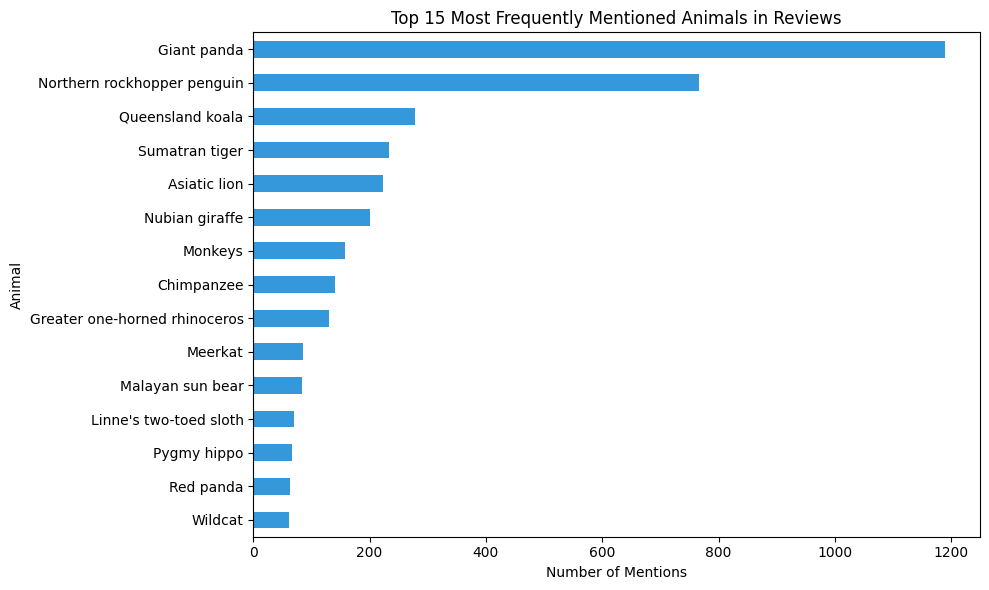

In [17]:
import matplotlib.pyplot as plt

# Count number of times each animal was mentioned (including duplicates per sentence)
mention_counts = (
    animal_sentences_df.explode("species")["species"]
    .value_counts()
    .sort_values(ascending=False)
)

# Plot top 15
mention_counts.head(15).plot(
    kind="barh",
    figsize=(10, 6),
    color="#3498db"
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 15 Most Frequently Mentioned Animals in Reviews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## Step 6: How Do People Feel About Each Animal?
---

Now that we know **which animals are mentioned most**, let's go one step further: we want to understand the **emotion or tone** behind each sentence.

Was the visitor...

- Excited to see the giraffes?

- Indifferent about the meerkats?

- Annoyed that the penguins weren't visible?

This process is called **sentiment analysis** - a technique that uses Natural Language Processing (NLP) to automatically detect the **emotional tone** of a sentence or phrase.

We'll apply sentiment analysis to each animal-related sentence. This will allow us to:

- Measure which animals get the most *positive* or *negative* feedback

- Spot *controversial* animals with mixed reactions

- Build visualisations to summarise how the zoo's animals are perceived overall

Let's dive in!

In [18]:
# === Load sentiment model ===
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import pandas as pd

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create pipeline with batch processing enabled
sentiment_model = pipeline(
    "sentiment-analysis", 
    model=model, 
    tokenizer=tokenizer,
    batch_size=32,  # Process 32 sentences at once
    truncation=True,
    max_length=512
)

# === Run Sentiment Analysis on Sentences that Mention Animals ===

def get_sentiment_batch(texts):
    """Process multiple texts at once for better efficiency"""
    try:
        # Process all texts in batch
        outputs = sentiment_model(texts)
        
        # Map labels to readable format
        label_map = {
            "LABEL_0": "negative",
            "LABEL_1": "neutral", 
            "LABEL_2": "positive"
        }
        
        results = []
        for output in outputs:
            results.append({
                "Sentiment": label_map[output["label"]],
                "Sentiment Score": output["score"]
            })
        
        return pd.DataFrame(results)
    except Exception as e:
        # Return error results for the batch
        return pd.DataFrame([{
            "Sentiment": "error",
            "Sentiment Score": 0.0
        }] * len(texts))

# Process sentences in batches with progress bar
batch_size = 32
sentences = animal_sentences_df["review_sentence"].tolist()
all_results = []

print("Running sentiment analysis on animal-related sentences...")

# Process in batches with tqdm progress bar
for i in tqdm(range(0, len(sentences), batch_size), desc="Processing batches"):
    batch = sentences[i:i+batch_size]
    batch_results = get_sentiment_batch(batch)
    all_results.append(batch_results)

# Combine all results
sentiment_results = pd.concat(all_results, ignore_index=True)

# Add results to the DataFrame
animal_sentences_df[["Sentiment", "Sentiment Score"]] = sentiment_results

# Preview the result
print(f"\nCompleted sentiment analysis on {len(animal_sentences_df)} sentences!")
animal_sentences_df.head()

Device set to use cpu


Running sentiment analysis on animal-related sentences...


Processing batches: 100%|██████████| 85/85 [04:45<00:00,  3.36s/it]


Completed sentiment analysis on 2690 sentences!


,review_sentence,animals,spans,norm_animals,species,Sentiment,Sentiment Score
3,It's a little bit hilly (especially on way up to see lions and tigers) but well worth the climb uphill to see such beautiful animals.,"[lions, tigers]","[[53, 58], [63, 69]]","[lion, tiger]","[Asiatic lion, Sumatran tiger]",positive,0.919433
16,The zoo was clean and tidy and the group loved it with the penguins being a firm favourite.,[penguins],"[[59, 67]]",[penguin],[Northern rockhopper penguin],positive,0.974308
21,Loved seeing all the different animals especially the penguins and giraffes!,"[penguins, giraffes]","[[54, 62], [67, 75]]","[penguin, giraffe]","[Northern rockhopper penguin, Nubian giraffe]",neutral,0.645479
28,We were lucky enough to get a good look at the sloth who put on a little show!,[sloth],"[[47, 52]]",[sloth],[Linne's two-toed sloth],positive,0.877192
29,The penguins were great too.,[penguins],"[[4, 12]]",[penguin],[Northern rockhopper penguin],positive,0.934811


#### What Did We Learn from the Sentiment Scores?

We now have a powerful dataset!
Each sentence is tagged with:

- The **animals** it mentions

- Whether it was **positive**, **neutral**, or **negative**

- A **confidence score** between 0 and 1

This sets us up for some really interesting questions:

- Which animals got the *happiest* reviews?

- Which ones triggered complaints or mixed feelings?

- How does public opinion vary between species?

To answer these, let's summarise everything visually in **Step 6**.

---
## Step 7: Visualise Animal Sentiments
---

We've now tagged each animal-related sentence with a **sentiment label** - positive, neutral, or negative - and a confidence score.

Let's bring this data to life with some visualisations!

We'll explore:

- **How often each animal was mentioned**

- **What the overall sentiment was for each one**

- **Which animals got the most praise - or criticism**

This helps us answer questions like:
> _“Which animals were the stars of the zoo?”_  
> _“Were there any surprises or mixed reviews?”_


#### Most Positively Mentioned Animals (by Count)

Let's start by looking at the **top 15 animals with the highest number of positive mentions**. These are the ones that visitors talked about most enthusiastically overall - not just because they were visible, but because they made an impression.

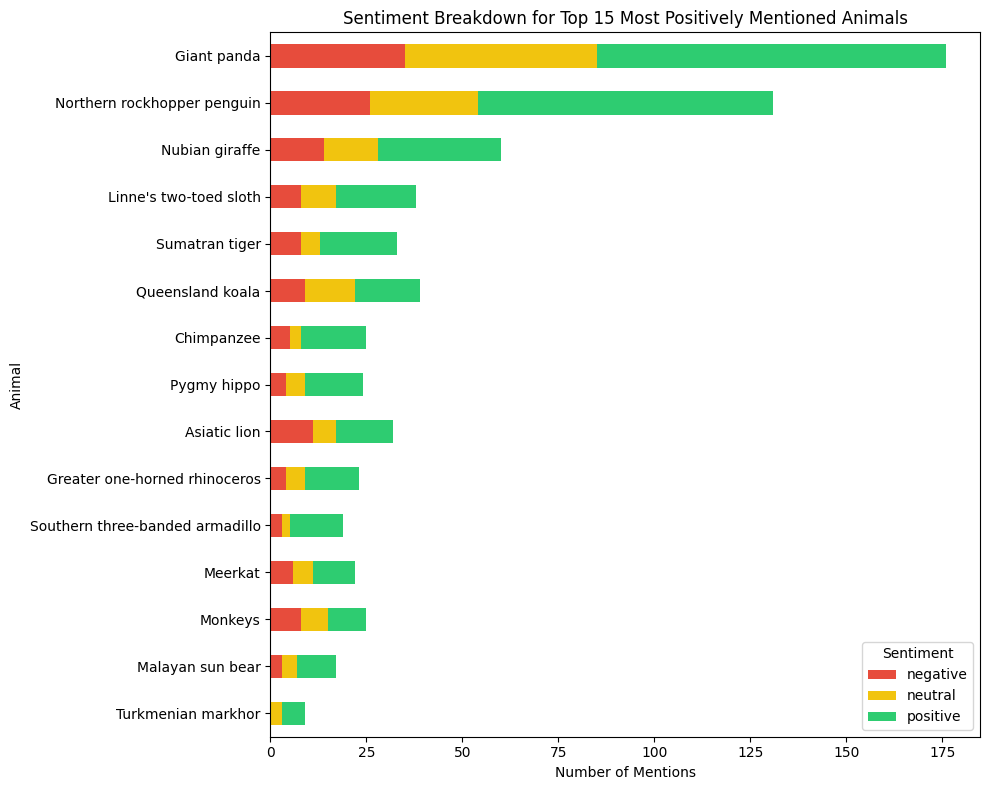

In [19]:
import matplotlib.pyplot as plt

# Prepare a summary table: count of sentiments per animal
summary_table = (
    animal_sentences_df.explode("species")
    .groupby(["species", "Sentiment"])
    .size()
    .unstack(fill_value=0)
    .sort_values(by="positive", ascending=False)
)

# Plot the top 15 animals by number of positive mentions
top_animals = summary_table.head(15)

top_animals[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 8),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Sentiment Breakdown for Top 15 Most Positively Mentioned Animals")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Most Loved Animals (by Proportion)

Sometimes, animals that aren't mentioned very often still generate **overwhelmingly positive** feedback when they are.

In this chart, we look at the **top 10 animals with the highest proportion of positive mentions** - so we can see who really impressed their fans, even if they weren't the most famous residents.

To keep things fair, we only include animals that had at least 5 total mentions. This avoids misleading results from animals that were only mentioned once - for example, a single glowing sentence might make an obscure animal seem like the most loved overall, even if no one else talked about it.

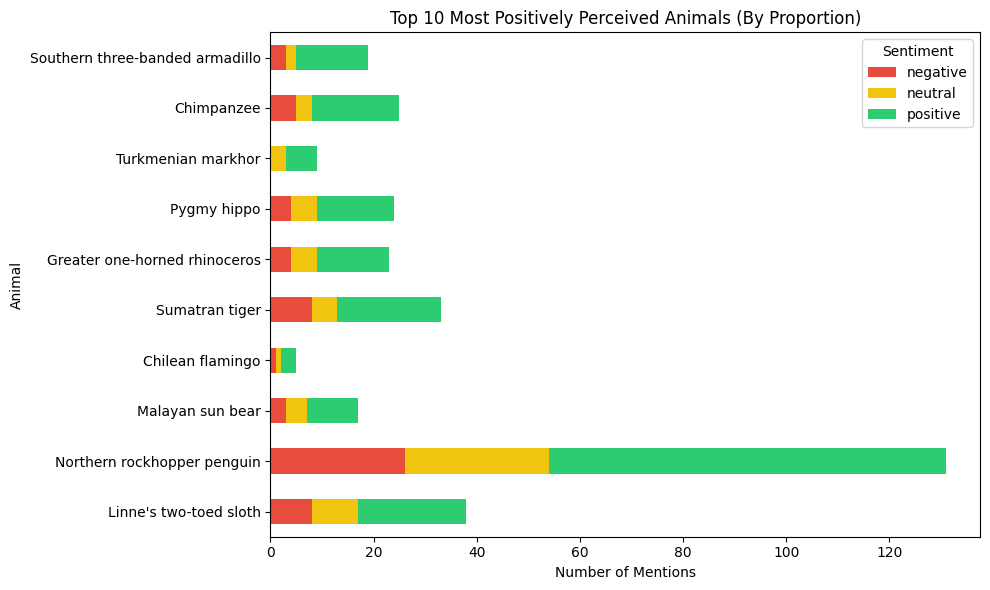

In [20]:
# Add total mentions
summary_table["Total"] = summary_table.sum(axis=1)

# Filter for animals with at least 5 total mentions
filtered = summary_table[summary_table["Total"] >= 5].copy()

# Calculate proportion of positive mentions
filtered["Positive Proportion"] = filtered["positive"] / filtered["Total"]

# Sort by positive proportion
most_positively_perceived = filtered.sort_values("Positive Proportion", ascending=False).head(10)

# Plot
most_positively_perceived[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 10 Most Positively Perceived Animals (By Proportion)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Most Criticised Animals (by Count)

Now let's flip our attention to animals that received **the most negative mentions overall**.

This helps answer questions like:

> _“Which animals did visitors complain about most?”_  
> _“Are there animals that consistently came up in negative reviews?”_

This chart shows the **top 10 animals with the highest total number of negative mentions**, regardless of how often they were praised or mentioned neutrally.

**Keep in mind:**
Animals on this list might not be universally disliked - but they may have:

- Been **hard to spot**

- Had **high expectations** attached to them

- Lived in **underwhelming enclosures**

- Or had **other issues** that disappointed visitors


Try writing the code **yourself** to generate this plot.

<div style="
  background: #e8f8f5;
  border-left: 6px solid #1abc9c;
  padding: 10px 16px;
  border-radius: 6px;
  margin-top: 12px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
">
  <strong>Hint:</strong>
  This task is very similar to the chart you created for <em>Most Positively Mentioned Animals (by Count)</em> - but now you'll want to <strong>sort by negative mentions</strong> instead.
</div>

In [21]:
# Write your code here

<details style="
  background: #fef9e7;
  border-left: 6px solid #f4d03f;
  padding: 10px;
  border-radius: 8px;
  margin-top: 10px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
">
<summary style="font-weight: bold; cursor: pointer;">Click to see the solution if you get stuck</summary>

<div style="overflow-x: auto; padding-top: 10px;">

```python
# Sort by number of negative mentions
most_negative_by_count = summary_table.sort_values("negative", ascending=False).head(10)

# Plot
most_negative_by_count[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 10 Most Criticised Animals (By Count)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
```
</details>

#### Most Criticised Animals (by Proportion)

Instead of raw counts, let's now consider **which animals received a higher share of negative feedback relative to how often they were mentioned**.

This helps surface animals that might not have been criticised the most overall - but when they were talked about, the tone wasn't great.

*We'll again limit to animals with **at least 5 total mentions**.*


Have a go at writing the code yourself!

<div style="
  background: #e8f8f5;
  border-left: 6px solid #1abc9c;
  padding: 10px 16px;
  border-radius: 6px;
  margin-top: 12px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
">
  <strong>Hint:</strong> Think back to how we calculated the <em>positive proportion</em> earlier - this is almost identical.<br><br>
  What needs to change is:
  <ul style="margin-top: 4px; margin-bottom: 0;">
    <li>Which column you divide by total</li>
    <li>Which column you sort by</li>
    <li>And of course, the chart title and labels</li>
  </ul>
</div>

In [22]:
# Write your code here

<details style="
  background: #fef9e7;
  border-left: 6px solid #f4d03f;
  padding: 10px;
  border-radius: 8px;
  margin-top: 10px;
  margin-bottom: 12px;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
">
<summary style="font-weight: bold; cursor: pointer;">Click to see the solution if you get stuck</summary>

<div style="overflow-x: auto; padding-top: 10px;">

```python
# Calculate proportion of negative mentions
filtered["Negative Proportion"] = filtered["negative"] / filtered["Total"]

# Sort by negative proportion
most_negatively_perceived = filtered.sort_values("Negative Proportion", ascending=False).head(10)

# Plot
most_negatively_perceived[["negative", "neutral", "positive"]].plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
    color=["#e74c3c", "#f1c40f", "#2ecc71"]
)

plt.xlabel("Number of Mentions")
plt.ylabel("Animal")
plt.title("Top 10 Most Criticised Animals (By Proportion)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
```
</div>
</details>


#### Why Does This Matter?

These sentiment insights aren't just fun - they're genuinely **valuable for zoo staff and management**.

Knowing which animals people love most (and why) can help with:

- **Marketing and social media:** Showcasing crowd favourites

- **Signage and storytelling:** Adding extra info near popular enclosures

- **Experience design:** Improving visibility or engagement around less-loved animals

- **Education efforts:** Highlighting lesser-known species that people do enjoy

And when an animal consistently draws negative mentions, it might be worth investigating:

- Is the enclosure hard to access?

- Is the animal usually inactive or hidden?

- Are expectations mismatched with what visitors experience?

*In short:* this kind of data helps the zoo turn visitor feedback into **actionable insights**.

---
## Step 8: Why Do People Feel That Way?
---

We've seen which animals were mentioned most positively or negatively - both by **total number of mentions** and by **proportion of feedback**.

But so far, we've only looked at **how often** people said good or bad things.

We haven't yet explored:

> _Why do people like or dislike each animal?_  
> _What exactly are they saying about them?_

For animals with just a few mentions, we could simply read through their comments.

But what if an animal was mentioned **dozens or even hundreds of times**?

Manually reading through all those sentences, annotating what people liked or disliked, and trying to summarise it would take **a very long time** - especially if we’re doing this for multiple animals.

We'd need to:

- Read and understand each sentence

- Categorise or tag each opinion

- Look for common themes

- Then write a summary ourselves

That's **slow**, **repetitive**, and prone to **human error or bias**.

This is exactly where **language models** shine. They can process large amounts of text and generate a summary that captures the **core themes and sentiments**, giving us a quick but meaningful overview of what people are saying.

Let's see how that works in Step 8!

---
## Step 9: Summarise Visitor Opinions with a Language Model
---

Let's now use a **Large Language Model (LLM)** to help us make sense of what visitors actually said about each animal.

Instead of reading through every sentence ourselves, we'll ask the model to:

- Understand the full set of comments for one animal

- Identify common themes and sentiments

- Generate a short, natural-language summary

This gives us a **quick and readable overview** - especially useful when we have dozens (or hundreds!) of mentions.

#### What's a Language Model (LLM)?

A **Language Model** is a type of artificial intelligence (AI) trained to understand and generate human language.

- It has read **huge amounts of text** - like books, articles, and online conversations.

- It has learned the **patterns of language** - how ideas connect, what words tend to go together, and what kinds of answers people expect.

- You can give it a **prompt** (like “Summarise these sentences”) - and it will try to respond like a human would.

When a Language Model is trained on billions of words and has billions of parameters (internal weights), we call it a **Large Language Model**, or **LLM**.

Famous examples include:

- ChatGPT

- Claude

- Mistral

- LLaMA

- Gemini

#### How Will We Use It?

We'll ask the LLM to **read all the visitor comments** about a specific animal and **generate a short summary**.

This will help us quickly uncover:

- Common reasons why people liked it

- Typical issues or disappointments

- Patterns in the feedback (e.g., excitement, boredom, confusion)

This is **especially helpful** when:

- There are **dozens or hundreds** of mentions

- You want to **save time** and avoid reading everything manually

- You need to make **decisions** about animal care, signage, or marketing


#### How Does It Actually Work?

1. We collect all the sentences where an animal was mentioned.

2. We create a **prompt** like:
   > “Below is a collection of review sentences that mention the *animal_name*. Summarise what people said specifically about the *animal_name*. Include common opinions, emotional reactions, and noteworthy experiences. Do not mention other animals or general zoo facilities. Only refer to the 'animal'. Visitor comments: *reviews_text*.”

3. We feed the prompt and sentences into the LLM.

4. The LLM generates a natural-language summary - just like a human might write.

The result is a quick and human-readable **snapshot** of public opinion.


#### Example Output

Here's what it might look like when we summarise two animals:

<div style="
  background: #eaf2f8;
  border-left: 6px solid #3498db;
  padding: 14px 16px;
  border-radius: 6px;
  margin-top: 16px;
  margin-bottom: 14px;
  max-width: 100%;
  overflow-wrap: break-word;
  box-sizing: border-box;
">
  <p style="margin: 0; font-size: 14px;"><strong>🐧 penguin</strong><br>
  <em>→ Visitors frequently mentioned how playful and active the penguins were, especially when swimming. Some also noted they were fun to watch with kids. A few comments mentioned difficulty seeing them during warmer weather.</em></p>

  <br>

  <p style="margin: 0; font-size: 14px;"><strong>🦒 giraffe</strong><br>
  <em>→ People often described the giraffes as majestic and gentle. Many reviews praised how close visitors could get to them, though some noted long queues near the enclosure.</em></p>
</div>


In order to do this, we will start by **creating a file that collects sentences from the reviews** that talk about a given animal. We will then **copy the content of this file and feed it into ChatGPT together with our prompt**.

<div style="
  border-left: 5px solid #ffc107;
  background: #fff8e1;
  padding: 0.75em 1em;
  margin-top: 1em;
  max-width: 100%;
  box-sizing: border-box;
  overflow-wrap: break-word;
  overflow-x: auto;
  border-radius: 6px;
">
  <strong>Tip:</strong>
  <ul style="margin-top: 4px; margin-bottom: 0;">
    <li>Use `ctrl + a` to select all content in a file</li>
    <li>Use `ctrl + c` to copy the selected content</li>
    <li>Use `ctrl + v` to paste the copied content</li>
  </ul>
</div>

In [23]:
# Set animals to summarise (make sure that the names match the ones in our dictionary from Step 4!)
ANIMALS_TO_SUMMARISE = ["Giant panda"]  # change or extend this list as needed
MAX_CHAR_PER_PROMPT = 10000  # safeguard for long inputs

# Use this as your sentence-level DataFrame
sentence_df = animal_sentences_df  # or rename earlier if preferred

# Dictionary to store summaries
animal_summaries = {}

for animal in ANIMALS_TO_SUMMARISE:
    # Step 1: Mention filter with robust matching
    animal_sentences = sentence_df[
        sentence_df["species"].apply(
            lambda x: isinstance(x, (list, tuple)) and any(animal.lower() == a.strip().lower() for a in x if isinstance(a, str))
        )
    ]

    # Step 2: Keep only opinionated sentences
    animal_sentences = animal_sentences[
        animal_sentences["Sentiment"].isin(["positive", "negative"])
    ]

    if animal_sentences.empty:
        animal_summaries[animal] = "(No comments found for this animal.)"
        continue

    # Combine sentences into one string (truncated if too long)
    text_block = "\n".join(animal_sentences["review_sentence"].tolist())[:MAX_CHAR_PER_PROMPT]

    text_file = open(f"{animal.replace(' ', '_')}_comments.txt", "w")
    text_file.write(text_block)
    text_file.close()

The output should be a `.txt` file with a collection of sentences referring to the animal we chose. Open it and see if the output is correct. If no file has been created, go back to the code block above and check that the name you wrote actually corresponds to one of the animals in the zoo, as shown in the dictionary in **Step 4**.

---
## Bonus Task: Experiment, Reflect, and Recommend
---

Now that you've seen how a **Large Language Model (LLM)** can summarise visitor opinions, it's your turn to explore further!

#### Play Around with the Prompt

Can you get different types of summaries?

- Try rewording the `prompt`:
  - “Write a fun, informal review of what people think about the *animal*.”
  - “List three common complaints people have about the *animal*'s enclosure.”

- Make it more detailed, playful, or emotional - and see how the tone changes!

#### Try Different Animals

Change the `ANIMALS_TO_SUMMARISE` list to explore other animals.

- Which animals have the most enthusiastic visitors?

- Which get mixed or negative reactions?

In [24]:
# Write your code here

---
## Final Reflection: Zoo Designers Wanted!
---

Imagine you work at the zoo and your job is to improve the visitor experience.

Based on what you've read or summarised:

- What patterns did you notice?

- Which animals were most loved? Why?

- What animals do people want the most Edinburgh adds to their zoo?

- Were there any recurring issues people had?

Write down 1-2 ideas you would suggest to the zoo:

- It could be an improvement for one animal's enclosure

- Or a new idea for signage, events, or volunteer guides

Be creative - you're using data to make real-world decisions!